<a href="https://colab.research.google.com/github/mustafacavusoglu/Computer-Vision/blob/main/Unet_implement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-d977e794-801c-3a65-2cd2-2fe83043d501)


In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))


GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [ ]:
import os 
os.chdir('drive/My Drive/ColabNotebooks/unet_uydu/veriler')
dosyalar = os.listdir()
print(dosyalar)

['test_images.npy', 'test_images_labels.csv', 'train_images.npy', 'validation_images.npy', 'train_images_labels.csv', 'validation_images_labels.csv', 'train_labels.npy', 'validation_labels.npy', 'test_images_labels.gsheet', 'standart_unet.json', 'test_labels.npy', 'Setting.txt']


In [ ]:
from __future__ import absolute_import
from __future__ import print_function
import os
import keras.models as models
from keras.models import load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop,Adam,SGD
from keras import backend as K
import cv2
import numpy as np
import json

In [ ]:
def get_unet_512(input_shape=(512, 512, 3),num_classes=2,lr=0.002):
    inputs = Input(shape=input_shape)
    # 512

    down0a = Conv2D(64, (3, 3), padding='same')(inputs)
    down0a = BatchNormalization()(down0a)
    down0a = Activation('relu')(down0a)
    down0a = Conv2D(64, (3, 3), padding='same')(down0a)
    down0a = BatchNormalization()(down0a)
    down0a = Activation('relu')(down0a)
    down0a_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0a)
    # 256

    down0 = Conv2D(128, (3, 3), padding='same')(down0a_pool)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(128, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
    # 128

    down1 = Conv2D(256, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(256, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(512, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(512, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    center = Conv2D(1024, (3, 3), padding='same')(down2_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down2, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down1, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down0, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down0a, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128

    # classify
    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)

    #optimizer = Adam(learning_rate=lr)
    optimizer = RMSprop(learning_rate=lr)
    
    model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=["accuracy"])


    return model

In [ ]:
segnet_basic = get_unet_512(input_shape=(512, 512, 3), num_classes=2)
#segnet_basic.summary()

model_json = segnet_basic.to_json()
with open('standart_unet.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# model = 'standart_unet'

# path = model + '.json'

# json_file = open(path, 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# segnet_basic = model_from_json(loaded_model_json)
# os.chdir("../veriler")
train_x= np.load('train_images.npy')
train_y= np.load('train_labels.npy')

val_x= np.load('validation_images.npy')
val_y= np.load('validation_labels.npy')

print(train_x.shape)
print(train_y.shape)

(825, 512, 512, 3)
(825, 512, 512, 2)


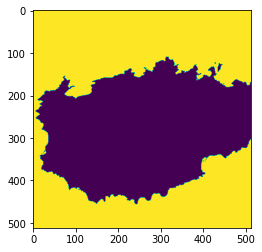

In [ ]:
plt.imshow(train_y[15,:,:,0])

In [ ]:
os.chdir("../testSonuclar")
os.getcwd()

'/content/drive/My Drive/ColabNotebooks/unet_uydu/testSonuclar'

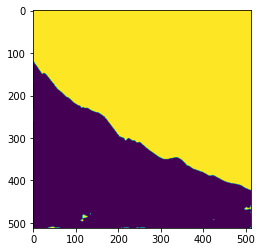

In [ ]:
import cv2
a = cv2.imread("sonuc_standart_unet_['test_85.tif'].tif")
plt.imshow(a[:,:,2])

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier



model = KerasClassifier(build_fn=get_unet_512, epochs = 10, batch_size = 1,verbose=0)
 
lr = [0.03,0.05,0.002,0.003,0.005]

param_grid = dict(lr=lr)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs = -1, scoring="accuracy", cv=3)

x_train = train_x
y_train = train_y

grid_result = grid.fit(x_train, y_train)
              
best_params = grid_result.best_params_
best_score = grid_result.best_score_

print(best_params)
print(best_score)

(825, 512, 512, 2)


ValueError: ignored

In [ ]:
#opt = Adam(lr=0.05, beta_1=0.5)

segnet_basic.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
#model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=["accuracy"])

segnet_basic = get_unet_512()
model = "segnet_basic"

segnet_basic.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])


filepath=model + 'weights--{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, period=1)

callbacks_list = [checkpoint]

nb_epoch = 10
batch_size = 2


history = segnet_basic.fit(train_x, train_y, 
                 batch_size=batch_size, 
                 callbacks=callbacks_list,
                 epochs=nb_epoch, verbose=1,
                 validation_data=(val_x, val_y)
                 )

Epoch 1/10
413/413 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.9687
Epoch 00001: saving model to segnet_basicweights--01.hdf5
413/413 [==============================] - 126s 306ms/step - loss: 0.1353 - accuracy: 0.9687 - val_loss: 0.4147 - val_accuracy: 0.9137
Epoch 2/10
413/413 [==============================] - ETA: 0s - loss: 0.0850 - accuracy: 0.9808
Epoch 00002: saving model to segnet_basicweights--02.hdf5
413/413 [==============================] - 125s 302ms/step - loss: 0.0850 - accuracy: 0.9808 - val_loss: 0.1536 - val_accuracy: 0.9713
Epoch 3/10
413/413 [==============================] - ETA: 0s - loss: 0.0736 - accuracy: 0.9829
Epoch 00003: saving model to segnet_basicweights--03.hdf5
413/413 [==============================] - 124s 301ms/step - loss: 0.0736 - accuracy: 0.9829 - val_loss: 0.1799 - val_accuracy: 0.9722
Epoch 4/10
413/413 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9874
Epoch 00004: saving model to segnet_b

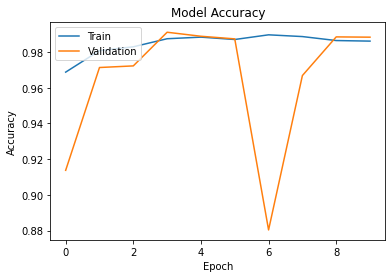

In [ ]:
os.chdir("../sonucGrafik")
hist_df = pd.DataFrame(history.history) 
hist_csv_file = model + '_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
    
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
isim_fig = model + '_fig_acc.png'
plt.savefig(isim_fig)

In [ ]:
os.chdir("../testSonuclar")
import csv
import keras
from keras.models import model_from_json
from sklearn.utils import class_weight

In [ ]:
model = 'standart_unet'

path = model + '.json'
os.chdir("../Unet")

json_file = open(path, 'r')
loaded_model_json = json_file.read()
json_file.close()
segnet_basic = model_from_json(loaded_model_json)

os.chdir("../veriler")
test_x= np.load('test_images.npy')

os.chdir("../sonuclar")
segnet_basic.load_weights('segnet_basicweights--10.hdf5')

os.chdir("../veriler")
test_name_ALL = 'test_images_labels.csv'
test_list = []     

with open(test_name_ALL, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        test_list.append(row)   



os.chdir("../testSonuclar")
deneme = list(range(test_x.shape[0]-1))

for i in deneme:
    A = np.zeros((1,512,512,3))
    A[0,:,:,:] = test_x[i,:,:,:]
    B = segnet_basic.predict(A)
    C = B[:,:,:,0]
    D = C>0.5
    D = D[0,:,:]
    isim = 'sonuc_' + model + '_' +str(test_list[i]) + '.tif'
    cv2.imwrite(isim, 255*D)

In [ ]:
path = r'/content/drive/My Drive/ColabNotebooks/unet_uydu/testSonuclar'

os.chdir(path)

os.getcwd()

dosya = os.listdir(path)

boyut = 512
sayi = len(dosya)


images = np.zeros((sayi,boyut,boyut),dtype=np.uint8)

i = -1
for data in dosya:
    i = i + 1
    im=cv2.imread(data,-1)
    np_im=np.asarray(im)
    images[i,:,:] = np_im
os.chdir("../sonuclar")
np_images=np.asarray(images)
np.save('Numpy_Sonuclar_Unet.npy',np_images)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import numpy as np

os.chdir("../veriler")
label = np.load('test_labels.npy')
os.chdir("../sonuclar")
sonuc = np.load('Numpy_Sonuclar_Unet.npy')

label = label[:,:,:,0]
label = label > 0.5
label = label.ravel()
sonuc = sonuc > 0.5
sonuc = sonuc.ravel()

print('Accuracy:')
print(np.mean(label == sonuc))

print('IoU Score (Jaccard Score):')
print(jaccard_score(label, sonuc))

print('F1 Score:')
print(f1_score(label, sonuc))

print('Precision:')
print(precision_score(label, sonuc))

print('Recall:')
print(recall_score(label, sonuc))

Accuracy:
0.9968596334042756
IoU Score (Jaccard Score):
0.9935806303996059
F1 Score:
0.9967799799503934
Precision:
0.9961973987372366
Recall:
0.9973632429550703
